In [1]:
import os
import sys
import numpy as np
import warnings
import pandas as pd
import matplotlib
from scipy import special
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

root_path = root_path = os.path.realpath('../..')
try:
    import auto_causality
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "auto-causality"))

from auto_causality import AutoCausality
from auto_causality.data_utils import preprocess_dataset
from auto_causality.scoring import Scorer

warnings.filterwarnings("ignore")

/Users/ava/PycharmProjects/auto-causality/venv/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Data Generation Process

Here we use a data generation process implemented by EconML for IV models and described as follows:

We construct the DGP as below. The instrument corresponds to a fully randomized recommendation of treatment. Then each sample complies with the recommendation to some degree. This probability depends on both the observed feature $X$ and an unobserved confounder that has a direct effect on the outcome


\begin{align}
W \sim \; & \text{Normal}(0,\, I_{n_w})   \tag{Observed confounders}\\
Z \sim \; & \text{Bernoulli}(p=0.5)   \tag{Instrument}\\
\nu \sim \; & \text{U}[0, 5] \tag{Unobserved confounder}\\
C \sim \; & \text{Bernoulli}(p=0.8 \cdot \text{Sigmoid}(0.4 \cdot X[0] + \nu))   \tag{Compliers when recommended}\\
C0 \sim \; & \text{Bernoulli}(p=0.006)   \tag{Non-Compliers when not recommended}\\
T = \; & C \cdot Z + C0 \cdot (1-Z)  \tag{Treatment}\\
y \sim \; & \theta \cdot T + 2 \cdot \nu + 5 \cdot (X[3]>0) + 0.1 \cdot \text{U}[0, 1]  \tag{Outcome}
\end{align}


In [2]:
def iv_dgp_econml(n=5000, p=10, true_effect=10):

    X = np.random.normal(0, 1, size=(n, p))
    Z = np.random.binomial(1, 0.5, size=(n,))
    nu = np.random.uniform(0, 5, size=(n,))
    coef_Z = 0.8
    C = np.random.binomial(
        1, coef_Z * special.expit(0.4 * X[:, 0] + nu)
    )  # Compliers when recomended
    C0 = np.random.binomial(
        1, 0.006 * np.ones(X.shape[0])
    )  # Non-compliers when not recommended
    T = C * Z + C0 * (1 - Z)
    y = (
        true_effect(X) * T
        + 2 * nu
        + 5 * (X[:, 3] > 0)
        + 0.1 * np.random.uniform(0, 1, size=(n,))
    )
    cov = [f"x{i}" for i in range(1, X.shape[1] + 1)]
    df = pd.DataFrame(X, columns=cov)

    df["y"] = y
    df["treatment"] = T
    df["Z"] = Z

    return df

In [3]:
# Dataset parameters
treatment = "treatment"
targets = ["y"]
instruments = ["Z"]
outcome = targets[0]

### Model Fitting (1): Constant Effect (ATE)

We define a constant treatment effect (ATE) to be searched by the auto-causality tool for all named IV estimators.

\begin{align}
\theta = \; & 7.5 \tag{ATE}\\
\end{align}

In [4]:
TRUE_EFFECT = 7.5

CONSTANT_EFFECT = lambda X: TRUE_EFFECT

data = iv_dgp_econml(n=20000, p=10, true_effect=CONSTANT_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    data, treatment, targets, instruments
)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)

Xtest_constant_te = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,random
17591,0.0,5.662729,0.0,-0.023812,1.609140,0.371102,-0.184003,-0.231473,-2.185286,-1.728480,-0.438191,0.377156,0.321961,1.0
8199,1.0,13.065081,1.0,1.292770,0.137540,-0.816210,0.699196,-0.662098,0.853141,1.082793,-0.115889,-0.022169,-1.705090,1.0
522,1.0,14.993478,1.0,1.340519,-0.271340,1.116128,-0.595146,-0.194440,1.139428,-0.289399,-1.098189,0.002337,1.120752,0.0
10647,0.0,4.352773,0.0,-0.444766,-0.117798,1.045438,-0.771418,-0.684443,-1.148572,-1.143796,0.795830,1.031679,2.261847,1.0
5168,0.0,13.251295,0.0,1.442926,-0.058393,-0.456565,0.129491,-1.532503,1.053520,0.697894,0.001705,-2.341247,0.638283,1.0


For each treatment effect example, we fit a list of 6 IV models, scoring them with an energy distance score. The dataset is split into train, validation and a hold-out test set, and we report scores for each.

As a baseline we use dowhy's simple IV estimator, implementing Ward's estimator and two-stage least squares (2SLS)
The other estimators are implemented by EconML with details [here](https://econml.azurewebsites.net/reference.html#instrumental-variable-cate-estimators)

The components time budget represent tuning budget allocated to each estimator model.

In [54]:
estimator_list = ["SimpleIV", "SparseLinearDRIV", "DMLIV", "OrthoIV", "LinearDRIV", "LinearIntentToTreatDRIV"]

ac_constant_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=300,
    propensity_model="dummy",
)

ac_constant_te.fit(train_df, treatment, outcome, features_W, features_X, instruments)


 We get the estimated effect for the best estimator by energy distance score

In [31]:
# score all estimators on the test set
def score_all_test(models, test_set):
    for est_name, scr in models.scores.items():
        try:
            causal_estimate = scr['estimator']
            # print(causal_estimate.estimator._treatment_name)
            scr['scores']['test'] = models.scorer.make_scores(
                causal_estimate,
                test_set,
                problem=models.problem,
                metrics_to_report=models.metrics_to_report
            )
        except Exception as e:
            print(e)
            pass


def ate_mse(scores, true_effect=TRUE_EFFECT):
    return  [(v-true_effect)**2 for v in scores]


In [24]:
def get_est_effects(models, test_x, te=TRUE_EFFECT):
    est_scores = []
    for est_name, scr in models.scores.items():
        est_effect = scr["estimator"].estimator.effect(test_x).mean()
        est_scores.append([est_name, est_effect, (est_effect-te)**2])

    return pd.DataFrame(est_scores, columns=["estimator", "estimated_effect", "ate_mse"])


In [25]:
%matplotlib inline

def graph_compare_estimators(model):
    colors = ([matplotlib.colors.CSS4_COLORS['black']] +
        list(matplotlib.colors.TABLEAU_COLORS) + [
        matplotlib.colors.CSS4_COLORS['lime'],
        matplotlib.colors.CSS4_COLORS['yellow'],
        matplotlib.colors.CSS4_COLORS['pink']
    ])


    plt.figure(figsize = (7,5))
    plt.title(outcome)

    m1 = "energy_distance"
    m2 = "ate"

    splits =  ["train", "validation", "test"]

    for (est, scr), col in zip(model.scores.items(), colors):
        try:
            scores  = scr["scores"]
            sc = [scores[v][m1] for v in splits]
            crv = ate_mse([scores[v][m2] for v in splits])
            plt.plot(sc, crv, color=col, marker="o", label=est)
            plt.scatter(sc[1:2],crv[1:2], c=col, s=70, label="_nolegend_" )
            plt.scatter(sc[2:],crv[2:], c=col, s=120, label="_nolegend_" )

        except Exception as e:
            print(e)
            pass

    plt.xlabel(m1)
    plt.ylabel(f"{m2}_MSE")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

    plt.grid()
    plt.show()


First we see the estimated effect for each model, and respective MSE compared with true effect

In [9]:
get_est_effects(ac_constant_te, Xtest_constant_te)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,7.423269,0.005888
1,iv.econml.iv.dml.DMLIV,3.581611,15.353776
2,iv.econml.iv.dml.OrthoIV,7.427995,0.005185
3,iv.econml.iv.dr.LinearDRIV,3.596863,15.234475
4,iv.econml.iv.dr.LinearIntentToTreatDRIV,7.116294,0.147230
5,iv.econml.iv.dr.SparseLinearDRIV,5.477806,4.089267


In the plots we show the energy distance scores on the train, validation and hold-out test sets compared with the mean squared error between estimated effect and the true effect

In [55]:
# Get non-optimal runs from each estimator and score on (energy distance, ate)
# ac_constant_te.results.results

In [35]:
len(ac_constant_te.results.results)

In [ ]:
all_trials = {}

for trial_key, results in ac_constant_te.results.results.items():
    # results (sub):
    # results (struct): train -> intrp, ate, ate_std, energy_distance
    pass

In [32]:
# Xtest_constant_te = test_df[features_X]
score_all_test(ac_constant_te, test_df)
ac_constant_te.scores

{'iv.auto_causality.models.SimpleIV': {'energy_distance': 0.005813656903304043,
  'estimator_name': 'iv.auto_causality.models.SimpleIV',
  'scores': {'train': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter at 0x1336e8340>,
    'ate': 7.423269271850586,
    'ate_std': 0.0,
    'energy_distance': 0.0011116351273621206},
   'validation': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter at 0x1336e8640>,
    'ate': 7.423269271850586,
    'ate_std': 0.0,
    'energy_distance': 0.005813656903304043},
   'test': {'intrp': <econml.cate_interpreter._interpreters.SingleTreeCateInterpreter at 0x13cebc910>,
    'ate': 7.423269271850586,
    'ate_std': 0.0,
    'energy_distance': 0.0045194934224648264}},
  'config': {'estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'}},
  'training_iteration': 0,
  'config/estimator': {'estimator_name': 'iv.auto_causality.models.SimpleIV'},
  'experiment_tag': 'exp',
  'time_total_s': 17.00895690

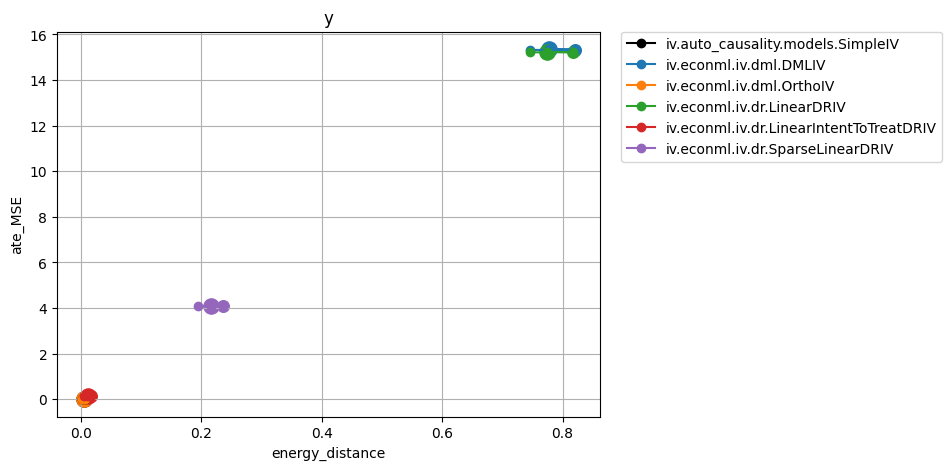

In [33]:
# score_all_test(ac_constant_te,Xtest_constant_te)
graph_compare_estimators(ac_constant_te)

### Model Fitting (2): Heterogeneous Treatment Effect

Here we replace the constant treatment effect with a linear treatment effect function of some covariates  to estimate heterogeneous effects.

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}

In [50]:
LINEAR_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] + X[:, 7])

synth_data = iv_dgp_econml(n=1000, p=10, true_effect=LINEAR_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    synth_data, treatment, targets, instruments
)
df_train, df_test = train_test_split(data_df, test_size=0.2)

Xtest_le = data_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,random
17591,0.0,5.662729,0.0,-0.023812,1.609140,0.371102,-0.184003,-0.231473,-2.185286,-1.728480,-0.438191,0.377156,0.321961,1.0
8199,1.0,13.065081,1.0,1.292770,0.137540,-0.816210,0.699196,-0.662098,0.853141,1.082793,-0.115889,-0.022169,-1.705090,1.0
522,1.0,14.993478,1.0,1.340519,-0.271340,1.116128,-0.595146,-0.194440,1.139428,-0.289399,-1.098189,0.002337,1.120752,0.0
10647,0.0,4.352773,0.0,-0.444766,-0.117798,1.045438,-0.771418,-0.684443,-1.148572,-1.143796,0.795830,1.031679,2.261847,1.0
5168,0.0,13.251295,0.0,1.442926,-0.058393,-0.456565,0.129491,-1.532503,1.053520,0.697894,0.001705,-2.341247,0.638283,1.0


In [51]:
ac_linear_te = AutoCausality(
    estimator_list=["OrthoIV"],
    verbose=3,
    components_verbose=2,
    time_budget=1200,
    components_time_budget=300,
    propensity_model="dummy",
)

ac_linear_te.fit(df_train, treatment, outcome, features_W, features_X, instruments)

[flaml.tune.tune: 09-18 10:08:24] {375} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 09-18 10:08:24] {506} INFO - trial 1 config: {'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}


Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks
Initial configs: [{'estimator': {'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'mc_agg': 'mean'}}]


OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/ava/PycharmProjects/auto-causality/venv/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[flaml.automl: 09-18 10:13:41] {2648} WARNING - Time taken to find the best model is 97% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.automl: 09-18 10:18:42] {2648} WARNING - Time taken to find the best model is 97% of the provided time budget and not all estimators' hyperparameter search converged. Consider increasing the time budget.
[flaml.tune.tune: 09-18 10:18:42] {118} INFO - result: {'energy_distance': 0.1487039377944841, 'estimator_name': 'iv.econml.iv.dml.OrthoIV', 'scores': {'train': {'intrp': <econml.cate_int

In [25]:
get_est_effects(ac_linear_te, Xtest_linear_te)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,0.409788,50.271103
1,iv.econml.iv.dml.DMLIV,-0.021106,56.567042
2,iv.econml.iv.dml.OrthoIV,0.105579,54.677467
3,iv.econml.iv.dr.LinearDRIV,0.022670,55.910463
4,iv.econml.iv.dr.LinearIntentToTreatDRIV,0.284875,52.058026
5,iv.econml.iv.dr.SparseLinearDRIV,0.162762,53.835059


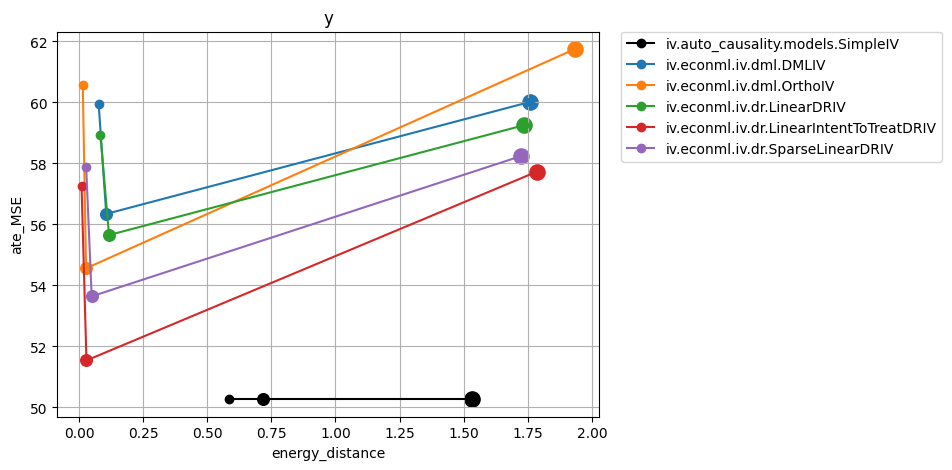

In [32]:
score_all_test(ac_linear_te, test_df)
graph_compare_estimators(ac_linear_te)

### Model Fitting (3): Non-linear Heterogeneous Treatment Effect

Finally we explore non-linear heterogeneous treatment effects with the function below:

\begin{align}
\theta = \; & 7.5  \cdot   (X[2] + X[7]) \tag{ATE}\\
\end{align}


In [17]:
QUADRATIC_EFFECT = lambda X: TRUE_EFFECT * (X[:, 2] ** 2)

data = iv_dgp_econml(n=5000, p=15, true_effect=QUADRATIC_EFFECT)
data_df, features_X, features_W = preprocess_dataset(
    data, treatment, targets, instruments
)
outcome = targets[0]
train_df, test_df = train_test_split(data_df, test_size=0.2)
Xtest = test_df[features_X]
train_df.head()

,treatment,y,Z,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,random
4883,0.0,5.642340,0.0,-0.166649,-0.037972,-2.462183,-0.661645,-1.274812,2.164241,-1.327964,-0.051017,0.313797,-0.090737,-0.743466,0.387685,0.239865,1.189409,-2.573799,0.0
2386,0.0,2.351887,1.0,-1.471137,0.640296,0.966827,-0.630309,2.840237,-1.403959,0.993368,-0.772781,-0.332158,-0.068102,-1.589545,-0.451900,-0.904239,-0.666099,-0.479209,1.0
4030,0.0,4.001770,1.0,-0.561018,0.464426,1.549468,-0.208957,-0.813260,-0.340804,0.438366,-0.605109,-0.281733,1.120829,0.689588,1.295571,1.067522,0.424703,-0.668093,0.0
2448,0.0,8.935736,0.0,-0.841337,0.889617,-0.589731,0.392965,-0.811575,-2.079406,-0.308424,-0.056356,2.167229,-0.510654,-0.144820,0.903875,0.287287,2.137014,-0.863859,1.0
3809,0.0,5.696070,0.0,-0.849518,0.074309,0.024217,0.373959,-0.040285,0.633923,0.904897,0.516027,0.547131,0.387320,1.336018,-0.242165,-0.037972,-1.099770,-0.093276,1.0


In [35]:
ac_quad_te = AutoCausality(
    estimator_list=estimator_list,
    verbose=3,
    components_verbose=2,
    components_time_budget=120,
    propensity_model="dummy",
)

ac_quad_te.fit(train_df, treatment, outcome, features_W, features_X, instruments)


In [26]:
get_est_effects(ac_quad_te, Xtest)

,estimator,estimated_effect,ate_mse
0,iv.auto_causality.models.SimpleIV,7.573547,0.005409
1,iv.econml.iv.dml.DMLIV,3.591073,15.279712
2,iv.econml.iv.dml.OrthoIV,7.395235,0.010976
3,iv.econml.iv.dr.LinearDRIV,3.757597,14.005577
4,iv.econml.iv.dr.LinearIntentToTreatDRIV,7.432717,0.004527
5,iv.econml.iv.dr.SparseLinearDRIV,5.355130,4.600468


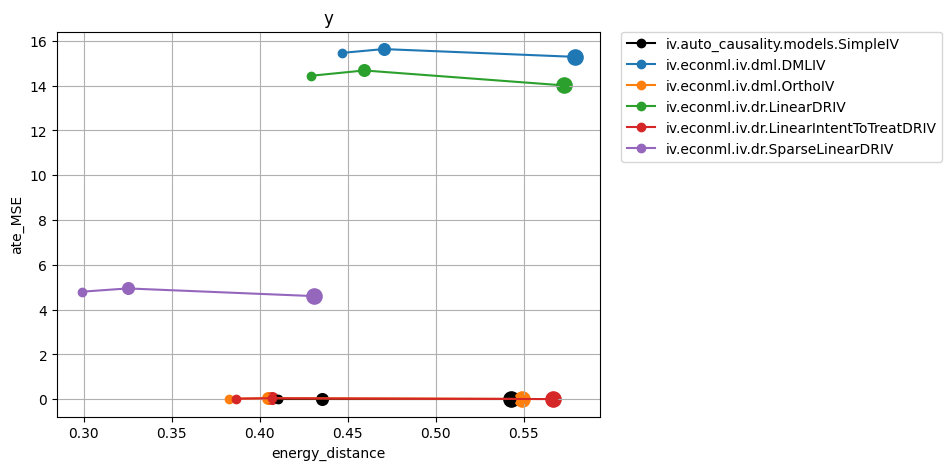

In [33]:
score_all_test(ac_quad_te, test_df)
graph_compare_estimators(ac_quad_te)
